In [1]:
import numpy as np
from sklearn.mixture import GaussianMixture as GMM
import matplotlib.pyplot as plt
from math import exp,pi,sqrt,inf,log,nan
import pickle
import pandas as pd
import matplotlib as mpl

Text(0.5, 1.0, 'tcells')

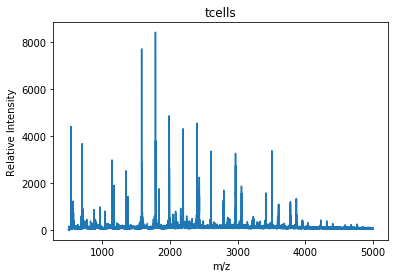

In [2]:
x = pd.read_csv('../Data/Glycan_profile/ms_data/human_tcells1.txt',delimiter = '\t')
x_mass = x['Centroid Mass'].to_numpy()
x_intensity = x['Relative Intensity'].to_numpy()
plt.plot(x_mass,x_intensity)
plt.xlabel('m/z')
plt.ylabel('Relative Intensity')
plt.title('tcells')

In [3]:
# Binning 
n_bins = 180
m_lowest = 500
m_highest = 5000
l_bin = (m_highest - m_lowest)/n_bins

mass = np.zeros(n_bins,)
Intensity = np.zeros(n_bins,)

mass[0] = m_lowest + l_bin/2
for i in range(n_bins):
    m_low = mass[i] - l_bin/2
    m_high = mass[i] + l_bin/2
    
    mask1 = x_mass[:] >= m_low
    mask2 = x_mass[:] <  m_high
    mask = np.all([mask1,mask2],0)
    
    if np.any(mask):
        Intensity[i] = x_intensity[mask].max()
    else:
        Intensity[i] = 0
        
    if i != n_bins-1:
        mass[i+1] = mass[i] + l_bin

In [4]:
# Defining the probability of am/z value being glycan
p = np.round(1-np.exp(-Intensity/Intensity.max()),2)

# Generating population of glycans
N_samples = 1000
Ns        = Intensity.size

Imax = 100
I = Imax* Intensity/Intensity.max()
#pop = np.zeros(Ns)

samples = np.empty(0)
for i in range(Ns):
    pop = 0
    for j in range(N_samples):
        if (np.random.rand() <= p[i]):
            pop += np.random.poisson(I[i],1)
            
    v_append = i*np.ones(int(pop),)
    samples  = np.append(samples,v_append)
    
samples = samples.reshape(-1,1)   

In [5]:
prob = np.zeros(180,)
for i in range(180):
    prob[i] = np.size(samples[samples == i])
prob = prob/(prob.sum())   

In [6]:
f = lambda x,mu,sigma: 1/sqrt(2*pi*sigma**2) * exp(-(x-mu)**2/(2*sigma**2))  

def Dkl(p,q):
    mask = p >= 1e-10
    return np.sum(p[mask] * np.log(p[mask]/q[mask]))


def g_func(x,p,w,mu,sigma):
    Nx = np.size(x)
    Nc = np.size(mu)
    g_temp = np.zeros(Nx,)
    for i in range(Nx):
        fj = np.zeros(Nc,)
        for j in range(Nc):
            fj[j] = w[j]*f(i,mu[j],sigma[j])
        g_temp[i] = p[i]*np.log(np.sum(fj))
    return g_temp.sum()

def Q_func(x,theta,theta_hat,Nc,p):
    Nx = np.size(x)
    w_hat = theta_hat[:Nc]
    mu_hat = theta_hat[Nc:2*Nc]
    sigma_hat = theta_hat[2*Nc:3*Nc]
    
    w = theta[:Nc]
    mu = theta[Nc:2*Nc]
    sigma = theta[2*Nc:3*Nc]
    
    z_hat = z_comp(x,w_hat,mu_hat,sigma_hat) 
    
    q = np.zeros([Nx,Nc])
    for xi in x:
        for i in range(Nc):
            q[xi,i] = p[xi]*z_hat[xi,i]*log(w[i]*f(xi,mu[i],sigma[i])/z_hat[xi,i])
    
    return np.sum(q)     

# Random initial conditions
def random_initial(Nc,Nx):
    w = np.random.uniform(0,1,[Nc,])
    mu = np.random.uniform(0,Nx,[Nc,])
    sigma = np.random.uniform(0.1,sqrt(Nx),[Nc,])
    return w/w.sum(),mu,sigma
  
def z_comp(x,w,mu,sigma):
    Nx = np.size(x)
    Nc = np.size(mu)
    z_hat = np.zeros([Nx,Nc])
    for i in range(Nx):
        for j in range(Nc):
            z_hat[i,j]  = w[j]*f(i,mu[j],sigma[j])
        v  = z_hat[i,:].sum()
        if v != 0: 
            z_hat[i,:] = z_hat[i,:]/v
        else:
            z_hat[i,:] = 1/Nc
    return z_hat

def get_prob(w,mu,sigma,prob):
    Nx = np.size(prob)
    Nc = np.size(mu)
    p_gauss = np.zeros(Nx,)
    for i in range(Nx):
        temp = np.zeros(Nc,)
        for j in range(Nc):
            temp[j] = w[j]*f(i,mu[j],sigma[j])
        p_gauss[i] = np.sum(temp)
    return p_gauss

In [7]:
def EM_optim(Nc,p,Ni_max=50,obj_threshold=1e-5,sigma_cut =1):
    Nx = np.size(p)
    w, mu, sigma = random_initial(Nc,Nx)
    x = np.arange(Nx)
    
    z_hat = z_comp(x,w,mu,sigma)
    while np.any(np.isnan(z_hat)):
        w, mu, sigma = random_initial(Nc,Nx)
        z_hat = z_comp(x,w,mu,sigma)
    
    counter = 0
#    obj_func = inf*np.ones(int(Ni_max),)
    obj_func = inf
    obj_func_increment = inf
   
    while(counter < Ni_max):                #and obj_func_increment >= obj_threshold):
        z_hat = z_comp(x,w,mu,sigma)
        
        for i in range(Nc):
            w[i] = np.sum(z_hat[:,i]*p[:]) 
            
            func = lambda mu : np.sum(z_hat[:,i]*p[:]*(x - mu)**2)
            mu0 = 0
            try:
                ls_result =  ls(func,mu0)
                mu[i] = ls_result['x']
            except:
                mu[i] = nan
            sigma[i] = sqrt(np.sum(z_hat[:,i]*p[:]*(x - mu[i])**2/np.sum(z_hat[:,i]*p[:])))
            if sigma[i]<= sigma_cut:
                sigma[i] = sigma_cut
        w = w/w.sum()        
        obj_func_increment =  abs(obj_func - g_func(x,p,w,mu,sigma))
        obj_func =  g_func(x,p,w,mu,sigma)
        counter += 1
    return w,mu,sigma,obj_func                        

In [9]:
Nc = 20
D = np.zeros(Nc,)
w = [np.zeros(1)]*20
mu = [np.zeros(1)]*20
sigma = [np.zeros(1)]*20

for nc in range(Nc):
    print(nc)
    wj = [np.zeros(nc)]*200
    muj = [np.zeros(nc)]*200
    sigmaj = [np.zeros(nc)]*200
    obj_func = np.zeros(200,)
    
    for j in range(200):
        wjj,mujj,sigmajj,obj_func[j] = EM_optim(nc+1,prob)
#        print(obj_func)
#        obj_func[j] = obj_funcj
        wj[j] = wjj
        muj[j] = mujj
        sigmaj[j] = sigmajj
    max_j = int(np.where(obj_func == np.nanmax(obj_func))[0][0])
    
    w[nc] = wj[max_j]
    mu[nc] = muj[max_j]
    sigma[nc] = sigmaj[max_j]
    
    p_gauss = get_prob(w[nc],mu[nc],sigma[nc],prob)
    D[nc] = Dkl(prob,p_gauss)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [21]:
np.savetxt('Dkl_tcells',D)

In [11]:
name = 'GMM_tcells_200initialpoints'
with open(name+'.pkl', 'wb') as output:
            pickle.dump([w,mu,sigma], output, pickle.HIGHEST_PROTOCOL)   